In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import scipy
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
#from lightgbm import LGBMClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import gc
import sys
import shap
import imblearn

In [2]:
random.seed(246810)
np.random.seed(246810)

# Import data:

In [3]:
CURR_DIR = "./ieee-fraud-detection/"

datasets =  {}

for data_name in ["train_identity", "train_transaction", "test_identity", "test_transaction"]:
    data = pd.read_csv(CURR_DIR + data_name + ".csv")
    datasets[data_name] = data

datasets.keys()

dict_keys(['train_identity', 'train_transaction', 'test_identity', 'test_transaction'])

In [4]:
transaction_train = datasets['train_transaction']
identity_train = datasets['train_identity']

transaction_test = datasets['test_transaction']
identity_test = datasets['test_identity']

In [5]:
transaction_train.shape

(590540, 394)

In [6]:
transaction_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
transaction_train[transaction_train["isFraud"] == 1]["TransactionAmt"].mean()

149.2447785897534

In [8]:
transaction_train[transaction_train["isFraud"] == 1]["TransactionAmt"].std()

232.21216297086974

Columns in test set have wrong labels:

In [9]:
identity_test.columns = identity_test.columns.str.replace('^id-', 'id_', regex = True)

Merge data

In [10]:
#complete_train = transaction_train.merge(identity_train,on=['TransactionID'],how='left')
#complete_train.shape

complete_train = transaction_train.copy()
complete_test = transaction_test.copy()

#complete_test = transaction_test.merge(identity_test,on=['TransactionID'],how='left')
#complete_test.shape

There are some columns that besides being categorical, have a different type. Therefore, we explicitly assign their type

In [11]:
categorical_cols = ['TransactionID','ProductCD','card1','card2','card3','card4','card5','card6','P_emaildomain','R_emaildomain','M1',
'M2','M3','M4','M5','M6','M7','M8','M9','addr1','addr2']

numeric_cols = list(set(complete_train.columns) - set(categorical_cols)) 

for col in categorical_cols:
    if col in complete_train.columns:
        complete_train[col] = complete_train[col].astype('object')
        complete_test[col] = complete_test[col].astype('object')


# Missing values per column

In [12]:
# For different thresholds, this function gives us variables with that % of missings
def missing_info(dataset, max_percent_missings = 90):
    nrows = dataset.shape[0]
    ncols = dataset.shape[1]
    missings = np.transpose((1 - dataset.describe(include='all').loc[['count']] / nrows) * 100)
    missings = missings.rename(columns = {'count':'missing_percent'})
    missings.sort_values(by = ['missing_percent'], ascending = False, inplace = True)
    
    filter_missings  = missings['missing_percent'] > max_percent_missings
    
    print(f"Your complete data set has {nrows} observations and {ncols} variables")
    print(f"From those, {missings[filter_missings].shape[0]} have more than {max_percent_missings} % of missing values")
    
    print(f"Such variables are: \n {missings[filter_missings]}")
    return(missings[filter_missings],missings[~filter_missings])

In [13]:
cols_to_remove, cols_not_remove = missing_info(complete_train, 70)
cols_not_remove = cols_not_remove.index.values.tolist()

Your complete data set has 590540 observations and 394 variables
From those, 168 have more than 70 % of missing values
Such variables are: 
       missing_percent
dist2       93.628374
D7           93.40993
D13         89.509263
D14         89.469469
D12         89.041047
...               ...
V239        76.053104
V238        76.053104
V234        76.053104
V227        76.053104
V222        76.053104

[168 rows x 1 columns]


In [14]:
complete_train = complete_train[cols_not_remove]

cols_not_remove.remove('isFraud')
complete_test = complete_test[cols_not_remove]

In [15]:
complete_test.head()

,dist1,M5,M7,M9,M8,D5,M4,D2,V2,D11,...,C3,C9,C10,C11,C12,C13,C1,C2,C14,TransactionID
0,1.0,NaN,T,T,T,27.0,NaN,419.0,1.0,203.0,...,0.0,6.0,0.0,5.0,1.0,115.0,6.0,6.0,6.0,3663549
1,4.0,NaN,NaN,NaN,NaN,7.0,M0,149.0,1.0,634.0,...,0.0,2.0,0.0,1.0,1.0,12.0,3.0,2.0,2.0,3663550
2,2635.0,F,F,F,F,10.0,M0,137.0,1.0,136.0,...,0.0,4.0,0.0,2.0,0.0,22.0,2.0,2.0,2.0,3663551
3,17.0,NaN,NaN,NaN,NaN,41.0,NaN,42.0,1.0,242.0,...,0.0,2.0,0.0,2.0,0.0,7.0,5.0,2.0,4.0,3663552
4,6.0,NaN,F,T,T,0.0,NaN,22.0,1.0,22.0,...,0.0,5.0,0.0,6.0,0.0,14.0,6.0,6.0,6.0,3663553


In [16]:
y_train = complete_train['isFraud']

complete_train_copy = complete_train.copy()
complete_test_copy = complete_test.copy()

complete_train_copy.drop('isFraud', 1, inplace = True)
complete_train_copy.drop('TransactionID', 1, inplace = True)

complete_test_copy.drop('TransactionID', 1, inplace = True)

X_train = complete_train_copy
X_test = complete_test_copy

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


### Export data without missing imputation

In [17]:
# create a ZipFile object
#zipObj = ZipFile('no_clean_database.zip', 'w')
# Add multiple files to the zip
###X_train.to_csv("X_train.csv", index = False)
###X_test.to_csv("X_test.csv", index = False)
###y_train.to_csv("y_train.csv", index = False)
# close the Zip File
#zipObj.close()

## Missing imputation

In [18]:
# Update list of numerical and categorical variables:
numeric_cols = list(set(cols_not_remove) & set(numeric_cols))
categorical_cols = list(set(cols_not_remove) & set(categorical_cols))


In [19]:
# Fill the numeric variables with mean
for column in numeric_cols :
    median = complete_train[column].median()
    complete_test[column].fillna(median, inplace = True)
    complete_train[column].fillna(median, inplace = True)
    
# Treatment for categoricals
for column in categorical_cols :
    mode = complete_train[column].mode()[0]
    complete_test[column].fillna(mode, inplace = True)
    complete_train[column].fillna(mode, inplace = True)

In [20]:
y_train = complete_train['isFraud']

complete_train.drop('isFraud', 1, inplace = True)
complete_train.drop('TransactionID', 1, inplace = True)

complete_test.drop('TransactionID', 1, inplace = True)

X_train = complete_train
X_test = complete_test

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


### Export data with missing imputation

In [21]:
# create a ZipFile object
#zipObj = ZipFile('clean_database.zip', 'w')
# Add multiple files to the zip
####X_train.to_csv("X_train.csv", index = False)
###X_test.to_csv("X_test.csv", index = False)
###y_train.to_csv("y_train.csv", index = False)
# close the Zip File
#zipObj.close()

In [22]:
complete_train.shape

(590540, 224)

# Feature engineering

In [23]:
# P_emaildomain
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

email_suffix = ['com', 'net', 'edu']
for c in ['P_emaildomain']:
    X_train[c + '_bin'] = X_train[c].map(emails)
    X_test[c + '_bin'] = X_test[c].map(emails)
    
    X_train[c + '_suffix'] = X_train[c].map(lambda x: str(x).split('.')[-1])
    X_test[c + '_suffix'] = X_test[c].map(lambda x: str(x).split('.')[-1])
    
    X_train[c + '_suffix'] = X_train[c + '_suffix'].map(lambda x: 'other' if str(x) not in email_suffix else x)
    X_test[c + '_suffix'] = X_test[c + '_suffix'].map(lambda x: 'other' if str(x) not in email_suffix else x)

In [24]:
X_train = X_train.drop(['P_emaildomain'],axis=1)
X_test = X_test.drop(['P_emaildomain'],axis=1)

In [25]:
#Card1,2,3,4, they are categorical data but with too many categories. 
#Since we don't know the meaning of them, we can't group them.
#num of categories: card1:13244, card2:497, card3:115, card5:102
for num in ['card1','card2','card3','card4','card5','card6']:
    print(num +' '+ str(len(X_train[num].unique())))
    
for num in ['card1','card2','card3','card4','card5','card6']:
    print(num +' '+ str(len(X_test[num].unique())))

card1 13553
card2 500
card3 114
card4 4
card5 119
card6 4
card1 13244
card2 497
card3 115
card4 4
card5 102
card6 3


In [26]:
#So we group the transactions by each of the columns, 
#calculate the group average of transaction amount and drop the oringinal columns
X_train['TransactionAmt_to_mean_card1'] = X_train['TransactionAmt'] / X_train.groupby(['card1'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_mean_card2'] = X_train['TransactionAmt'] / X_train.groupby(['card2'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_mean_card3'] = X_train['TransactionAmt'] / X_train.groupby(['card3'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_mean_card5'] = X_train['TransactionAmt'] / X_train.groupby(['card5'])['TransactionAmt'].transform('mean')

X_test['TransactionAmt_to_mean_card1'] = X_test['TransactionAmt'] / X_train.groupby(['card1'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_mean_card2'] = X_test['TransactionAmt'] / X_train.groupby(['card2'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_mean_card3'] = X_test['TransactionAmt'] / X_train.groupby(['card3'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_mean_card5'] = X_test['TransactionAmt'] / X_train.groupby(['card5'])['TransactionAmt'].transform('mean')

In [27]:
X_train = X_train.drop(['card1','card2','card3','card5'],axis=1)
X_test = X_test.drop(['card1','card2','card3','card5'],axis=1)

In [28]:
#for similar reasons, we can do the same things to addr1 and addr2

#num of categories: addr1:292, addr2:72
for num in ['addr1','addr2']:
    print(num +' '+ str(len(X_train[num].unique())))

for num in ['addr1','addr2']:
    print(num +' '+ str(len(X_test[num].unique())))
    
X_train['TransactionAmt_to_mean_addr1'] = X_train['TransactionAmt'] / X_train.groupby(['addr1'])['TransactionAmt'].transform('mean')
X_train['TransactionAmt_to_mean_addr2'] = X_train['TransactionAmt'] / X_train.groupby(['addr2'])['TransactionAmt'].transform('mean')

X_test['TransactionAmt_to_mean_addr1'] = X_test['TransactionAmt'] / X_train.groupby(['addr1'])['TransactionAmt'].transform('mean')
X_test['TransactionAmt_to_mean_addr2'] = X_test['TransactionAmt'] / X_train.groupby(['addr2'])['TransactionAmt'].transform('mean')

addr1 332
addr2 74
addr1 292
addr2 72


In [29]:
X_train = X_train.drop(['addr1','addr2'],axis=1)
X_test = X_test.drop(['addr1','addr2'],axis=1)

In [30]:
#convert transaction time to hour & week
hour_tr = np.floor((X_train['TransactionDT']/3600) % 24)
week_tr = np.floor(X_train['TransactionDT']/(3600*24) % 7)
X_train = X_train.drop(['TransactionDT'],axis=1)
X_train = pd.concat((X_train,hour_tr),axis=1)
X_train = X_train.rename(columns={'TransactionDT': 'hour'})
X_train = pd.concat((X_train,week_tr),axis=1)
X_train = X_train.rename(columns={'TransactionDT': 'week'})

hour_te = np.floor((X_test['TransactionDT']/3600) % 24)
week_te = np.floor(X_test['TransactionDT']/(3600*24) % 7)
X_test = X_test.drop(['TransactionDT'],axis=1)
X_test = pd.concat((X_test,hour_te),axis=1)
X_test = X_test.rename(columns={'TransactionDT': 'hour'})
X_test = pd.concat((X_test,week_te),axis=1)
X_test = X_test.rename(columns={'TransactionDT': 'week'})

In [31]:
colname_tr = list(X_train.columns)
colname_te = list(X_test.columns)
#categorical data
categorical_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M6', 'M7', 'M8', 'M9', 'P_emaildomain_bin', 'P_emaildomain_suffix', 
                    'ProductCD', 'card4', 'card6'] 
num_col_tr = [ x for x in colname_tr if x not in categorical_cols]
num_col_te = [ x for x in colname_te if x not in categorical_cols]
#sorted(num_col)

In [32]:
#Standardization
from sklearn.preprocessing import StandardScaler
scaled_features_tr = X_train.copy()

features_tr = scaled_features_tr[num_col_tr]

# Use scaler of choice; here Standard scaler is used
scaler_tr = StandardScaler().fit(features_tr.values)
features_tr = scaler_tr.transform(features_tr.values)

scaled_features_tr[num_col_tr] = features_tr

scaled_features_te = X_test.copy()

features_te = scaled_features_te[num_col_te]

# Use scaler of choice; here Standard scaler is used
#scaler_te = StandardScaler().fit(features_te.values)
features_te = scaler_tr.transform(features_te.values)

scaled_features_te[num_col_te] = features_te

In [33]:
#One-Hot-Encoding
X_transaction = pd.get_dummies(scaled_features_tr, columns = categorical_cols, drop_first=True)
X_transaction_test = pd.get_dummies(scaled_features_te, columns = categorical_cols, drop_first=True)

In [34]:
X_transaction.columns

Index(['dist1', 'D5', 'D2', 'V2', 'D11', 'V1', 'V6', 'V7', 'V8', 'V9',
       ...
       'ProductCD_H', 'ProductCD_R', 'ProductCD_S', 'ProductCD_W',
       'card4_discover', 'card4_mastercard', 'card4_visa', 'card6_credit',
       'card6_debit', 'card6_debit or credit'],
      dtype='object', length=243)

# Modelling

In [35]:
y_transaction = y_train.copy()
feature_names = X_transaction.columns

In [36]:
X_transaction = scipy.sparse.csr_matrix(X_transaction.values)

In [37]:
np.where(feature_names == "TransactionAmt_to_mean_card3")

(array([206]),)

### Split the data in 80/20 partition for later testing

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_transaction, y_transaction, 
                                                    test_size=0.2, random_state=2020, stratify=y_transaction)

In [39]:
len(np.unique(X_train[:, 206].toarray()))

24717

## Logistic Regression For variable selection and bench marking

In [ ]:
from sklearn.metrics import precision_recall_curve


In [40]:
# coefficients with magnitude less than the mean are removed
import warnings
warnings.filterwarnings("ignore")
selector = SelectFromModel(estimator=LogisticRegression(max_iter=100, C=0.1)).fit(X_train, np.ravel(y_train))
# selector.estimator_.coef_
select_columns = selector.get_support()

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [45]:
selector_l1 = SelectFromModel(estimator=LogisticRegression(max_iter=100, C=0.1, penalty="l1", solver="saga"), threshold="mean").fit(X_train, np.ravel(y_train))
# selector.estimator_.coef_
select_columns_l1 = selector_l1.get_support()

In [43]:
np.sum(select_columns) # 61 features selected

62

In [47]:
np.where(select_columns_l1)

(array([  0,   1,   2,   6,  10,  15,  16,  17,  21,  22,  23,  24,  26,
         27,  32,  40,  41,  48,  49,  52,  57,  72,  74,  76,  77,  78,
         79,  80,  82,  86,  87,  92,  94,  98, 109, 111, 131, 147, 164,
        182, 195, 202, 206, 212, 213, 214, 215, 218, 219, 221, 222, 227,
        228, 230, 231, 234, 236, 238, 239, 240, 241]),)

In [48]:
np.where(select_columns)

(array([  2,  15,  21,  22,  23,  27,  40,  48,  51,  56,  75,  76,  77,
         78,  79,  80,  82,  85,  86,  88,  96,  97,  98, 115, 138, 142,
        143, 152, 157, 189, 191, 192, 194, 195, 196, 197, 198, 200, 201,
        202, 203, 206, 209, 212, 214, 215, 217, 220, 221, 222, 224, 226,
        230, 232, 233, 234, 236, 237, 238, 239, 240, 241]),)

In [49]:
# mutually selected 31 features
len([i for i in np.where(select_columns_l1)[0] if i in np.where(select_columns)[0]])

31

In [50]:
np.sum(select_columns) # 62 features selected

62

In [51]:
X_transaction.shape

(590540, 243)

In [52]:
selector.threshold_

0.18061752788947905

In [81]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [57]:
logistic_model = LogisticRegression(max_iter=100, C=0.1, penalty='l2')
logistic_model.fit(X_train[:, select_columns], np.ravel(y_train))
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), logistic_model.predict_proba(X_test[:, select_columns])[:, 1])

0.8173559854300528

In [82]:
print(accuracy_score(np.ravel(y_test), logistic_model.predict(X_test[:, select_columns])))
print(balanced_accuracy_score(np.ravel(y_test), logistic_model.predict(X_test[:, select_columns])))

0.9681816642395096
0.5580749340833178


In [78]:
recall_score(np.ravel(y_test), logistic_model.predict(X_test[:, select_columns]))

0.11710621824340672

In [79]:
precision_score(np.ravel(y_test), logistic_model.predict(X_test[:, select_columns]))

0.8161888701517707

In [41]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [42]:
import imblearn
over = SMOTE(sampling_strategy=0.1, k_neighbors=12)
under = RandomUnderSampler(sampling_strategy=0.9, random_state=0)
pipeline = Pipeline(steps=[('o',over),('u', under)])
X_train_tr, y_train_tr = pipeline.fit_resample(X_train, np.ravel(y_train))

In [43]:
Counter(y_train_tr)

Counter({0: 50655, 1: 45590})

In [42]:
logistic_model_l1 = LogisticRegression(max_iter=100, C=0.1, penalty='l1', solver="saga")
logistic_model_l1.fit(X_train[:, select_columns_l1], np.ravel(y_train))
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), logistic_model_l1.predict_proba(X_test[:, select_columns_l1])[:, 1])

0.8155338843934887

In [45]:
logistic_model_bal = LogisticRegression(max_iter=100, C=0.1, penalty='l2')
logistic_model_bal.fit(X_train_tr[:, select_columns], np.ravel(y_train_tr))
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), logistic_model_bal.predict_proba(X_test[:, select_columns])[:, 1])

0.8203971564688836

In [86]:
print(precision_score(np.ravel(y_test), logistic_model_bal.predict(X_test[:, select_columns])))
print(recall_score(np.ravel(y_test), logistic_model_bal.predict(X_test[:, select_columns])))
print(accuracy_score(np.ravel(y_test), logistic_model_bal.predict(X_test[:, select_columns])))
print(balanced_accuracy_score(np.ravel(y_test), logistic_model_bal.predict(X_test[:, select_columns])))

0.10134507550999346
0.7127994193080087
0.7687709553967556
0.7418000167388914


In [47]:
Bsamples = 30
rng = np.random.default_rng(2021)
coefficients = np.zeros((Bsamples, np.sum(select_columns)))
for i in range(Bsamples):
    select_index = rng.choice(X_train_tr.shape[0], size=X_train_tr.shape[0])
    logit = LogisticRegression(max_iter=100, C=0.1, penalty="l2")
    logit.fit(X_train_tr[np.ix_(select_index, select_columns)], np.ravel(y_train_tr[select_index]))
    coefficients[i, :] = logit.coef_[0]

In [48]:
Boostrap_estimate = np.std(coefficients, axis=0)

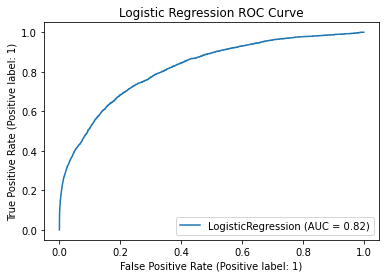

In [50]:
# display roc curve for the test set
RocCurveDisplay.from_estimator(logistic_model_bal, X_test[:, select_columns], np.ravel(y_test))
plt.title("Logistic Regression ROC Curve");

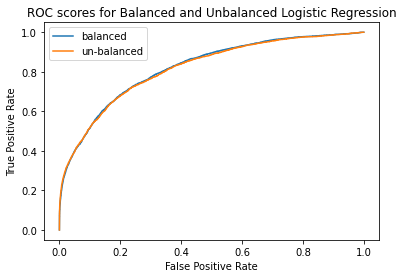

In [75]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.ravel(y_test), 
                                         logistic_model_bal.predict_proba(X_test[:, select_columns])[:, 1] , pos_label=1)
plt.plot(fpr, tpr, label="balanced")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC scores for Balanced and Unbalanced Logistic Regression")
fpr, tpr, thresholds = metrics.roc_curve(np.ravel(y_test), 
                                         logistic_model.predict_proba(X_test[:, select_columns])[:, 1] , pos_label=1)
plt.plot(fpr, tpr, label="un-balanced")
plt.legend()
plt.savefig('Logistic-plot-roc-compare.png', dpi=300)
plt.show()

In [ ]:
# display confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(logistic_model, X_test[:, select_columns], np.ravel(y_test))

In [ ]:
# change probability threhold
thres = np.linspace(0.01, 0.99, num=100)
best_accur = 0
for i in thres:
    y_pred_thres_low = logistic_model.predict_proba(X_test[:, select_columns])[:, 1] > i
    if np.sum(y_pred_thres_low == np.ravel(y_test))/y_test.shape[0] > best_accur:
        best_accur = np.sum(y_pred_thres_low == np.ravel(y_test))/y_test.shape[0] 
        print(i)
        print(best_accur)

In [ ]:
y_pred_thres_low = logistic_model.predict_proba(X_test[:, select_columns])[:, 1] > 0.4455
ConfusionMatrixDisplay.from_predictions(np.ravel(y_test), y_pred_thres_low)

In [ ]:
y_pred_thres_high = logistic_model.predict_proba(X_test[:, select_columns])[:, 1] > 0.9
ConfusionMatrixDisplay.from_predictions(np.ravel(y_test), y_pred_thres_high)

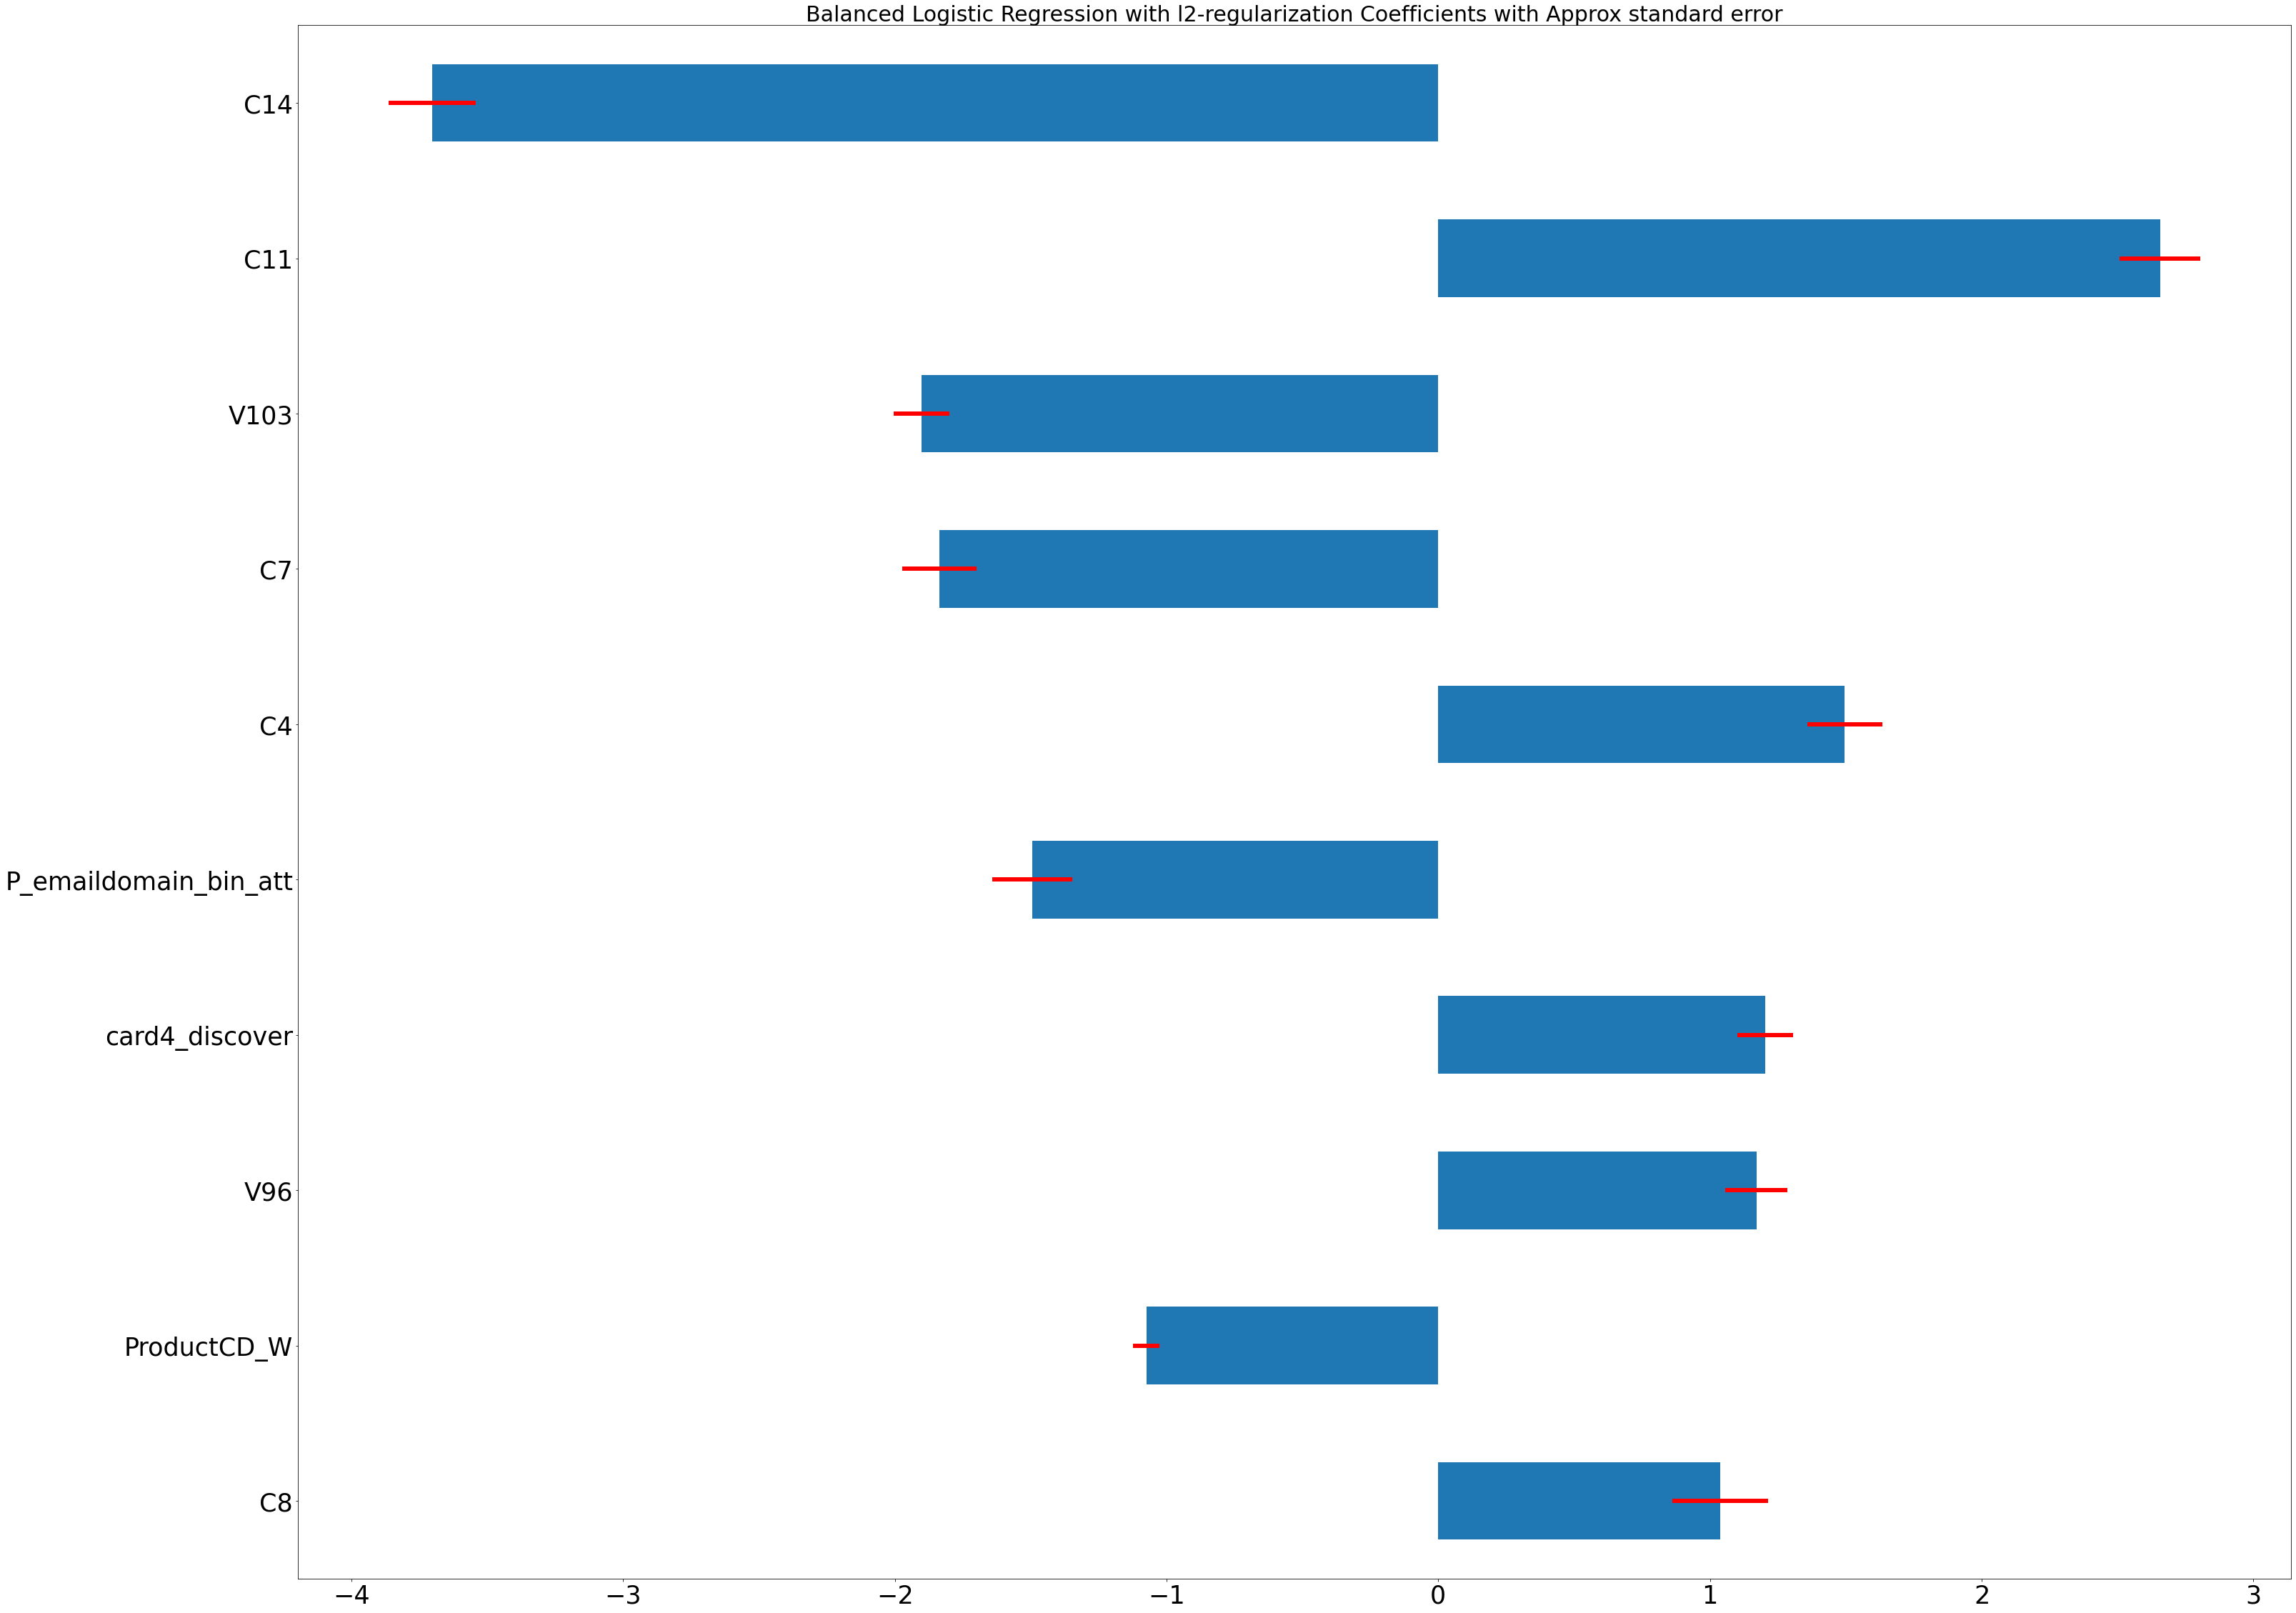

In [53]:
logistic_coef = (np.sort(np.abs(logistic_model_bal.coef_[0])))[::-1][:10]
coef_name = np.argsort(np.abs(logistic_model_bal.coef_[0]))[::-1][:10]
logistic_coef = logistic_coef * np.sign(logistic_model_bal.coef_[0][coef_name])
logistic_coefficients = pd.Series(logistic_coef
                                  , index=np.array(feature_names)[select_columns][coef_name])[::-1]
plt.figure(figsize=(50, 40))
pd.Series(logistic_coefficients).plot.barh(xerr=Boostrap_estimate[coef_name][::-1], ecolor="red",error_kw =dict({'elinewidth':6}))
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.title("Balanced Logistic Regression with l2-regularization Coefficients with Approx standard error", size=30)
plt.savefig('logistic-coef-bal.png', dpi=300);

In [72]:
from sklearn.linear_model import LogisticRegressionCV

In [73]:
p = np.sum(select_columns)
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
logistic_model_cv = LogisticRegressionCV(max_iter=100, Cs=[0.1], penalty='l2', cv=10, n_jobs=5)
logistic_model_cv.fit(X_train_tr[:, select_columns], np.ravel(y_train_tr))
coef_estimate = (np.mean(logistic_model_cv.coefs_paths_[1], axis=0)[0])[:p]
coef_stderr = ((np.std(logistic_model_cv.coefs_paths_[1], axis=0))[0])[:p]

In [54]:
logistic_coef = (np.sort(np.abs(coef_estimate)))[::-1][:10]
coef_index = np.argsort(np.abs(coef_estimate))[::-1][:10]
logistic_coef = logistic_coef * np.sign(coef_estimate[coef_index])
logistic_coefficients = pd.Series(logistic_coef, 
                                  index=(np.array(feature_names)[select_columns])[coef_index])[::-1]
#logistic_coefficients_cv = pd.Series(coef_estimate[0][:n], index=feature_names[select_columns])
plt.figure(figsize=(30, 20))
logistic_coefficients.plot.barh(xerr=Boostrap_estimate[coef_index][::-1], ecolor="red", error_kw =dict({'elinewidth':6}))
plt.xlabel("coefficient", size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylabel("feature", size=25)
plt.title("Logistic Regression with l2-regularization Coefficients with Approximate standard error", size=35);

NameError: name 'coef_estimate' is not defined

## Fit a Random Forest Classifier

In [72]:
# Not run this
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train_tr.shape[0], size=50000, replace=False)
parameters = {'n_estimators':[500, 1000], 'max_depth':[10,20,30], 'min_samples_split':[5, 10]}
best_rf = GridSearchCV(RandomForestClassifier(), parameters, scoring='roc_auc', cv=5, n_jobs=7)
best_rf.fit(X_train_tr[np.ix_(subsample, select_columns)], np.ravel(y_train_tr[subsample]))

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=7,
             param_grid={'max_depth': [10, 20, 30],
                         'min_samples_split': [5, 10],
                         'n_estimators': [500, 1000]},
             scoring='roc_auc')

In [76]:
best_rf.best_estimator_

RandomForestClassifier(max_depth=30, min_samples_split=5, n_estimators=1000)

In [73]:
roc_auc_score(np.ravel(y_test), best_rf.predict_proba(X_test[:, select_columns])[:, 1])

0.9073170990853741

In [76]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=50000, replace=False)

rf = RandomForestClassifier(n_jobs = 5, max_depth = 20, min_samples_split = 5, n_estimators = 500, 
                            random_state=1)
rf.fit(X_train[np.ix_(subsample, select_columns)], np.ravel(y_train.iloc[subsample]))

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       n_jobs=5, random_state=1)

In [61]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=50000, replace=False)

rf_l1 = RandomForestClassifier(n_jobs = 5, max_depth = 20, min_samples_split = 5, n_estimators = 500, 
                            random_state=1)
rf_l1.fit(X_train[np.ix_(subsample, select_columns_l1)], np.ravel(y_train.iloc[subsample]))

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       n_jobs=5, random_state=1)

In [79]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train_tr.shape[0], size=50000, replace=False)

rf_balance = RandomForestClassifier(n_jobs = 5, max_depth = 20, min_samples_split = 5, n_estimators = 500, 
                            random_state=1)
rf_balance.fit(X_train_tr[np.ix_(subsample, select_columns)], np.ravel(y_train_tr[subsample]))

RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=500,
                       n_jobs=5, random_state=1)

In [46]:
precision, recall, thresholds = precision_recall_curve(np.ravel(y_test), 
                                                       rf_balance.predict_proba(X_test[:, select_columns])[:, 1])

# best_rf.best_estimator_ # best random forest model found

In [47]:
from sklearn.metrics import  PrecisionRecallDisplay

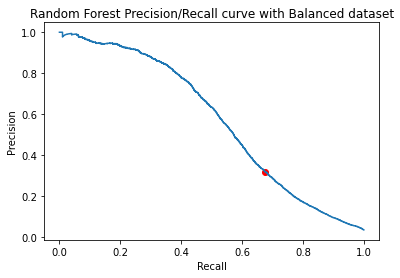

In [66]:
import matplotlib.pyplot as plt
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()
plt.scatter(0.675, 0.318, color='red')
plt.title("Random Forest Precision/Recall curve with Balanced dataset")
plt.show()

In [82]:
feature_import = pd.Series(rf.feature_importances_, index=feature_names[select_columns])
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)/np.sqrt(500)

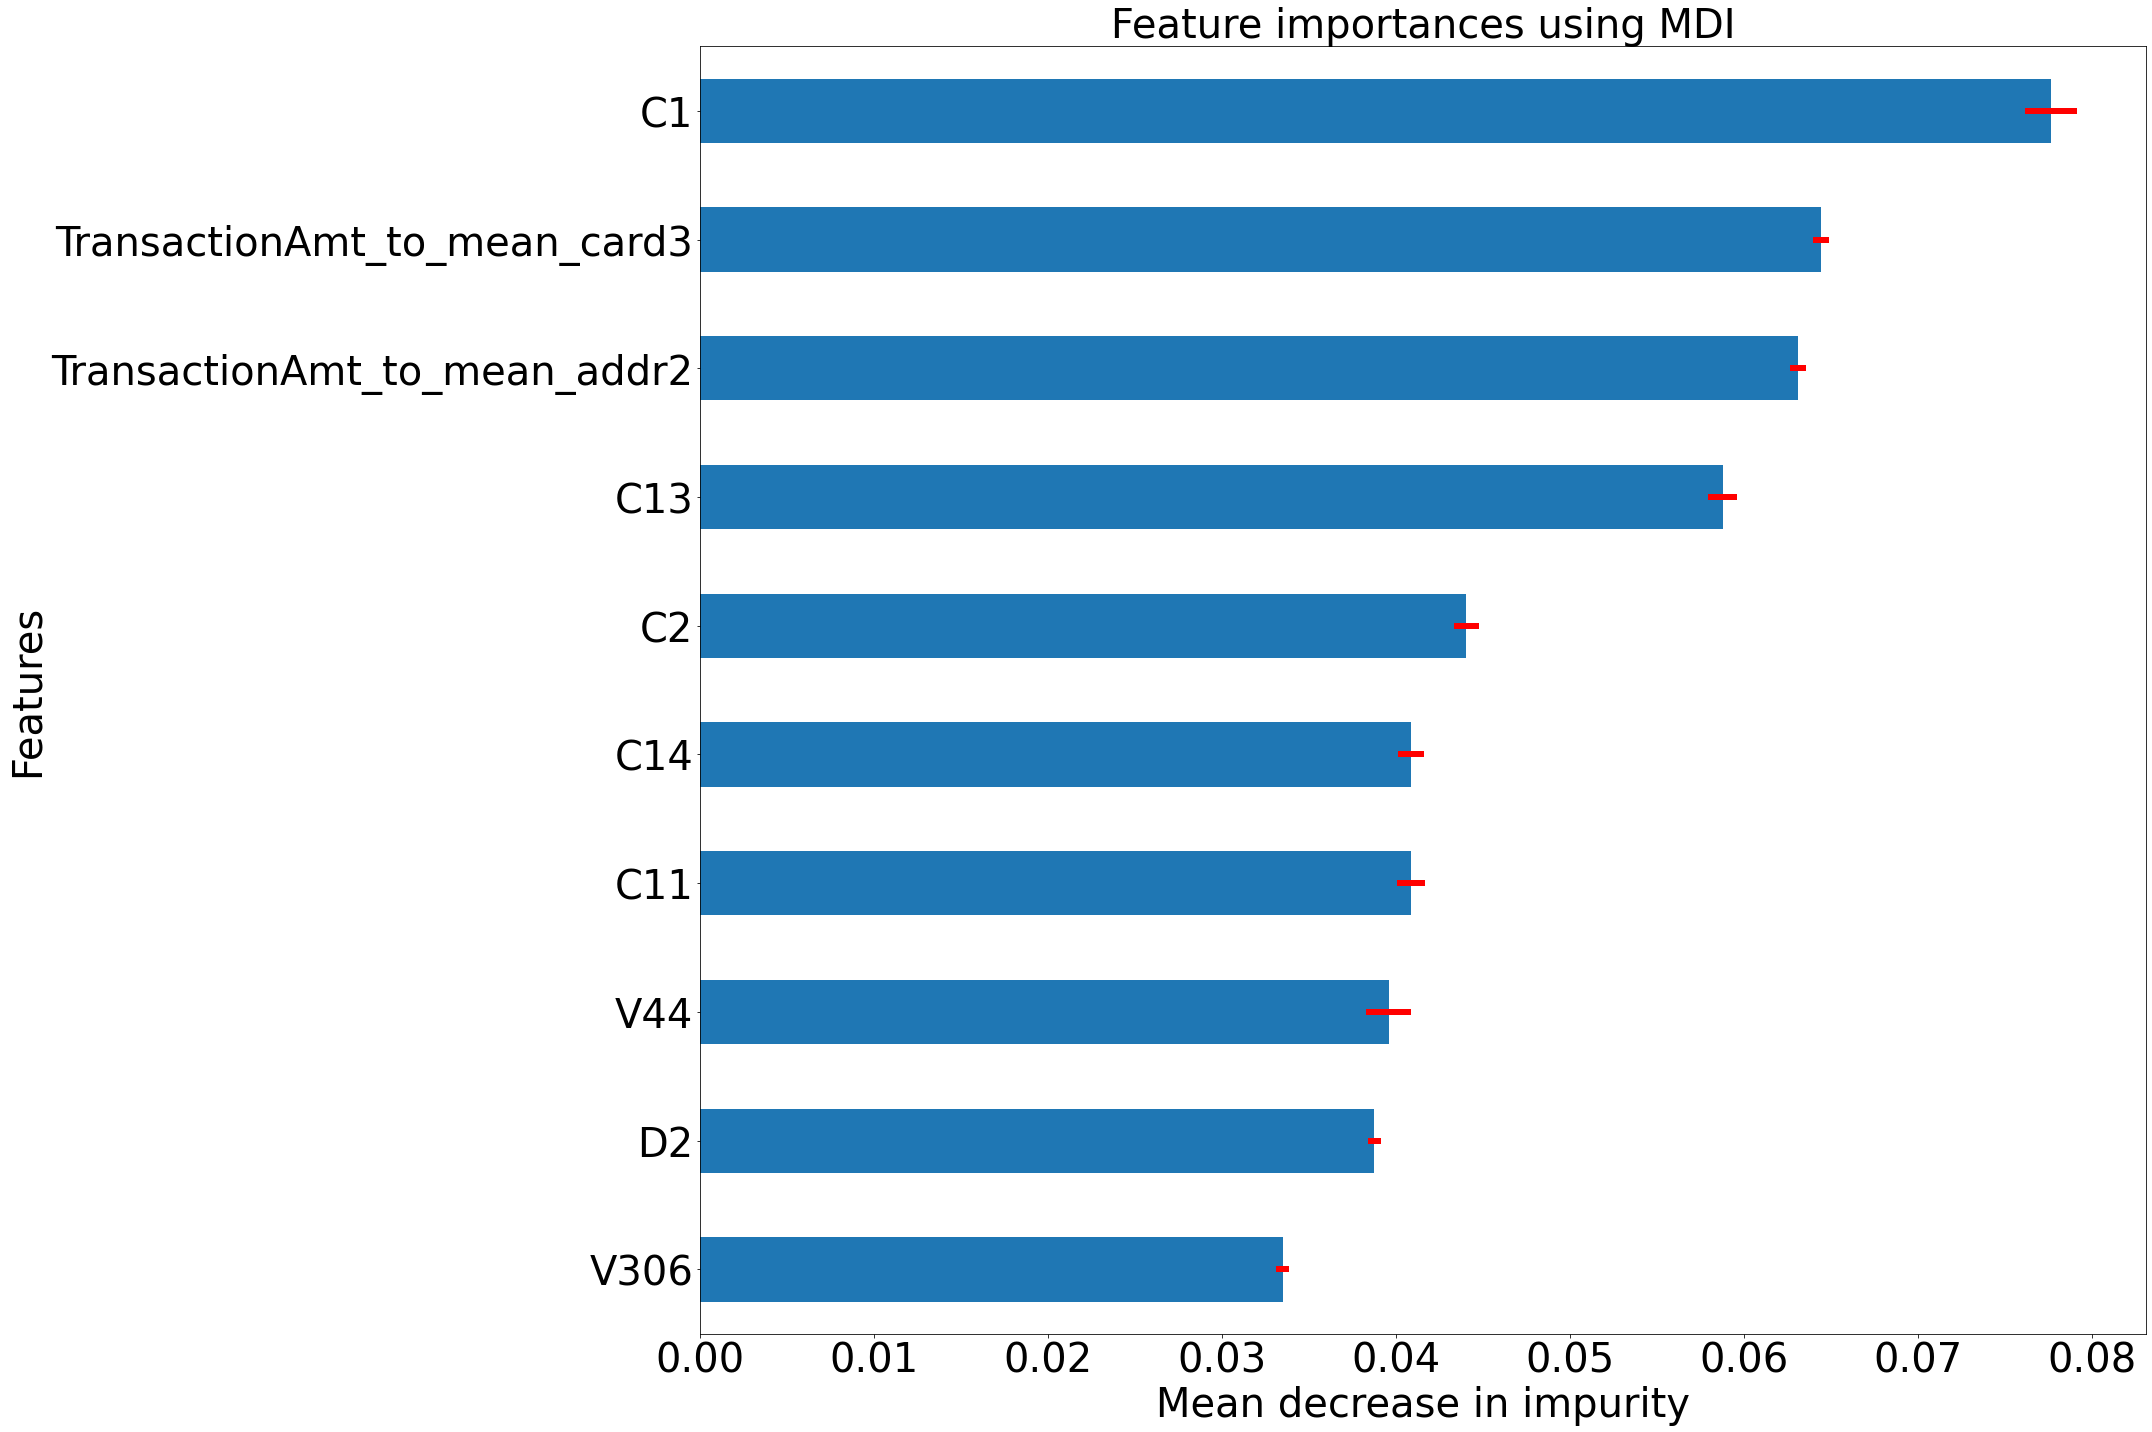

In [83]:
# error bars are standard error of the mean decrease impurity over all the decision trees
# in this case, there are 500 trees
feature_import_top_10 = (np.sort(rf.feature_importances_))[::-1][:10]
coef_name = np.argsort(rf.feature_importances_)[::-1][:10]

feature_import_top_10 = pd.Series(feature_import_top_10
                                  , index=np.array(feature_names)[select_columns][coef_name])[::-1]
fig, ax = plt.subplots(figsize=(30, 20))
feature_import_top_10.plot.barh(xerr=std[coef_name][::-1], ax=ax, ecolor="red", error_kw =dict({'elinewidth':6}))
ax.set_title("Feature importances using MDI", size=40)
ax.set_xlabel("Mean decrease in impurity", size=40)
ax.set_ylabel("Features", size=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
fig.tight_layout()

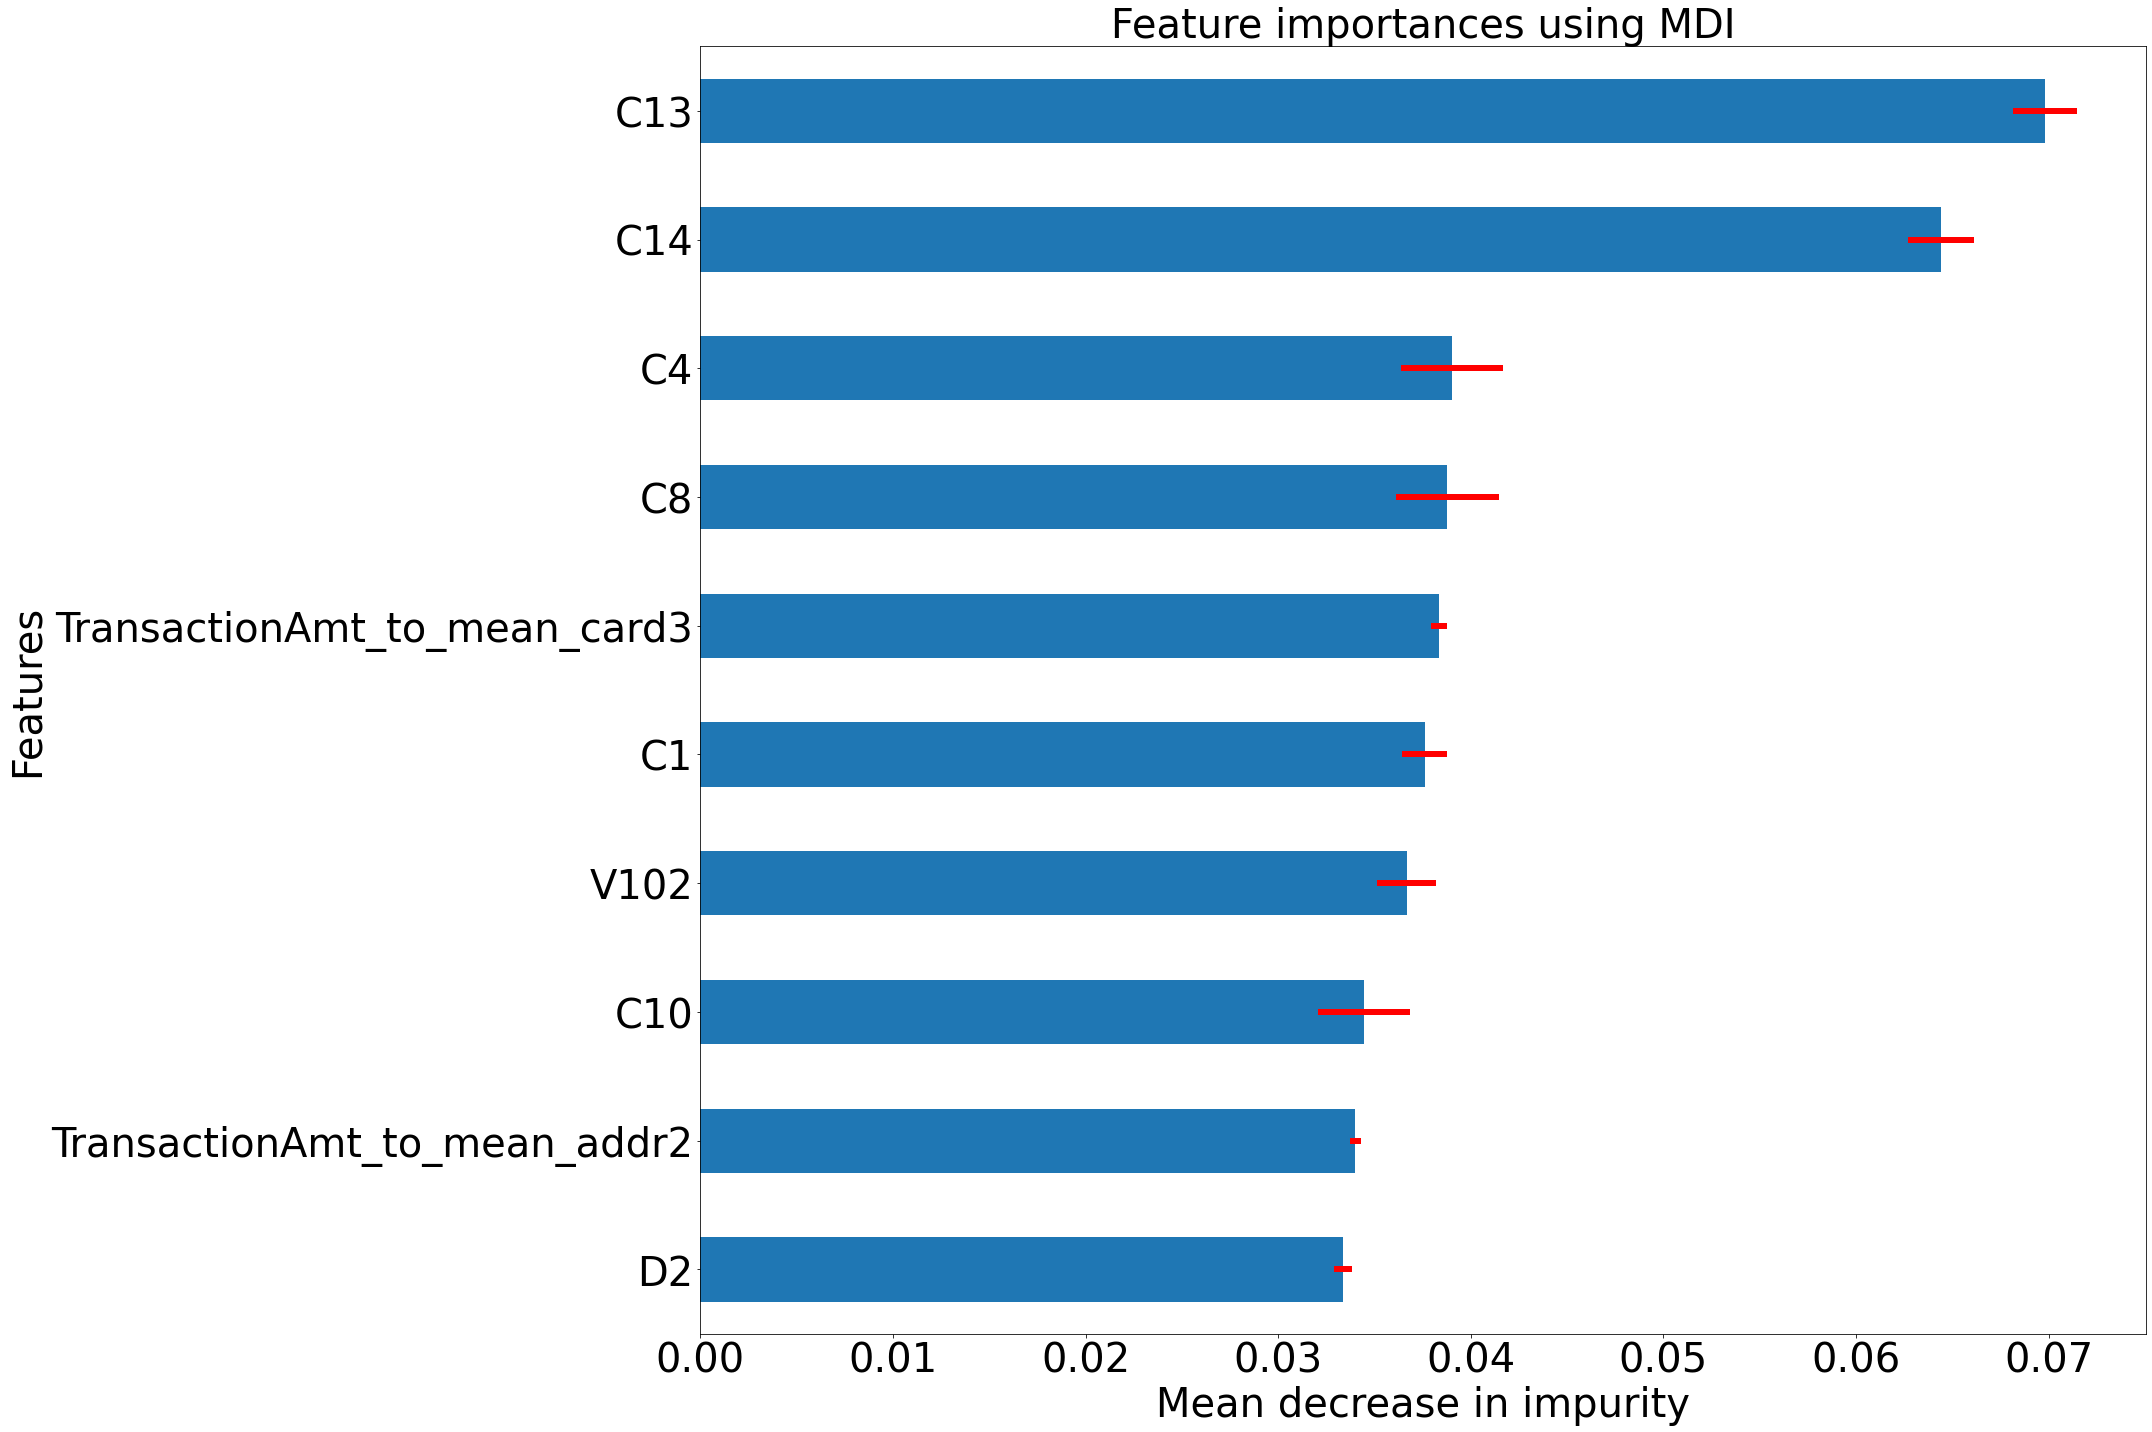

In [81]:
# error bars are standard error of the mean decrease impurity over all the decision trees
# for balanced dattaset
# in this case, there are 500 trees
std = np.std([tree.feature_importances_ for tree in rf_balance.estimators_], axis=0)/np.sqrt(500)
feature_import_top_10 = (np.sort(rf_balance.feature_importances_))[::-1][:10]
coef_name = np.argsort(rf_balance.feature_importances_)[::-1][:10]

feature_import_top_10 = pd.Series(feature_import_top_10
                                  , index=np.array(feature_names)[select_columns][coef_name])[::-1]
fig, ax = plt.subplots(figsize=(30, 20))
feature_import_top_10.plot.barh(xerr=std[coef_name][::-1], ax=ax, ecolor="red", error_kw =dict({'elinewidth':6}))
ax.set_title("Feature importances using MDI", size=40)
ax.set_xlabel("Mean decrease in impurity", size=40)
ax.set_ylabel("Features", size=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
fig.tight_layout()

In [75]:
# alternative feature importance (based on permutating the feature values)
rng = np.random.default_rng(2021)
subsample = rng.choice(X_test.shape[0], size=10000, replace=False)
results = permutation_importance(
    rf, X_test[np.ix_(subsample, select_columns)].toarray(), np.ravel(y_test.iloc[subsample]), n_repeats=30, 
    random_state=2021, n_jobs=5, scoring='roc_auc' 
)
feature_import_top_10 = (np.sort(results.importances_mean))[::-1][:10]
coef_name = np.argsort(results.importances_mean)[::-1][:10]
forest_importances = pd.Series(feature_import_top_10, 
                               index=np.array(feature_names)[select_columns][coef_name])[::-1]

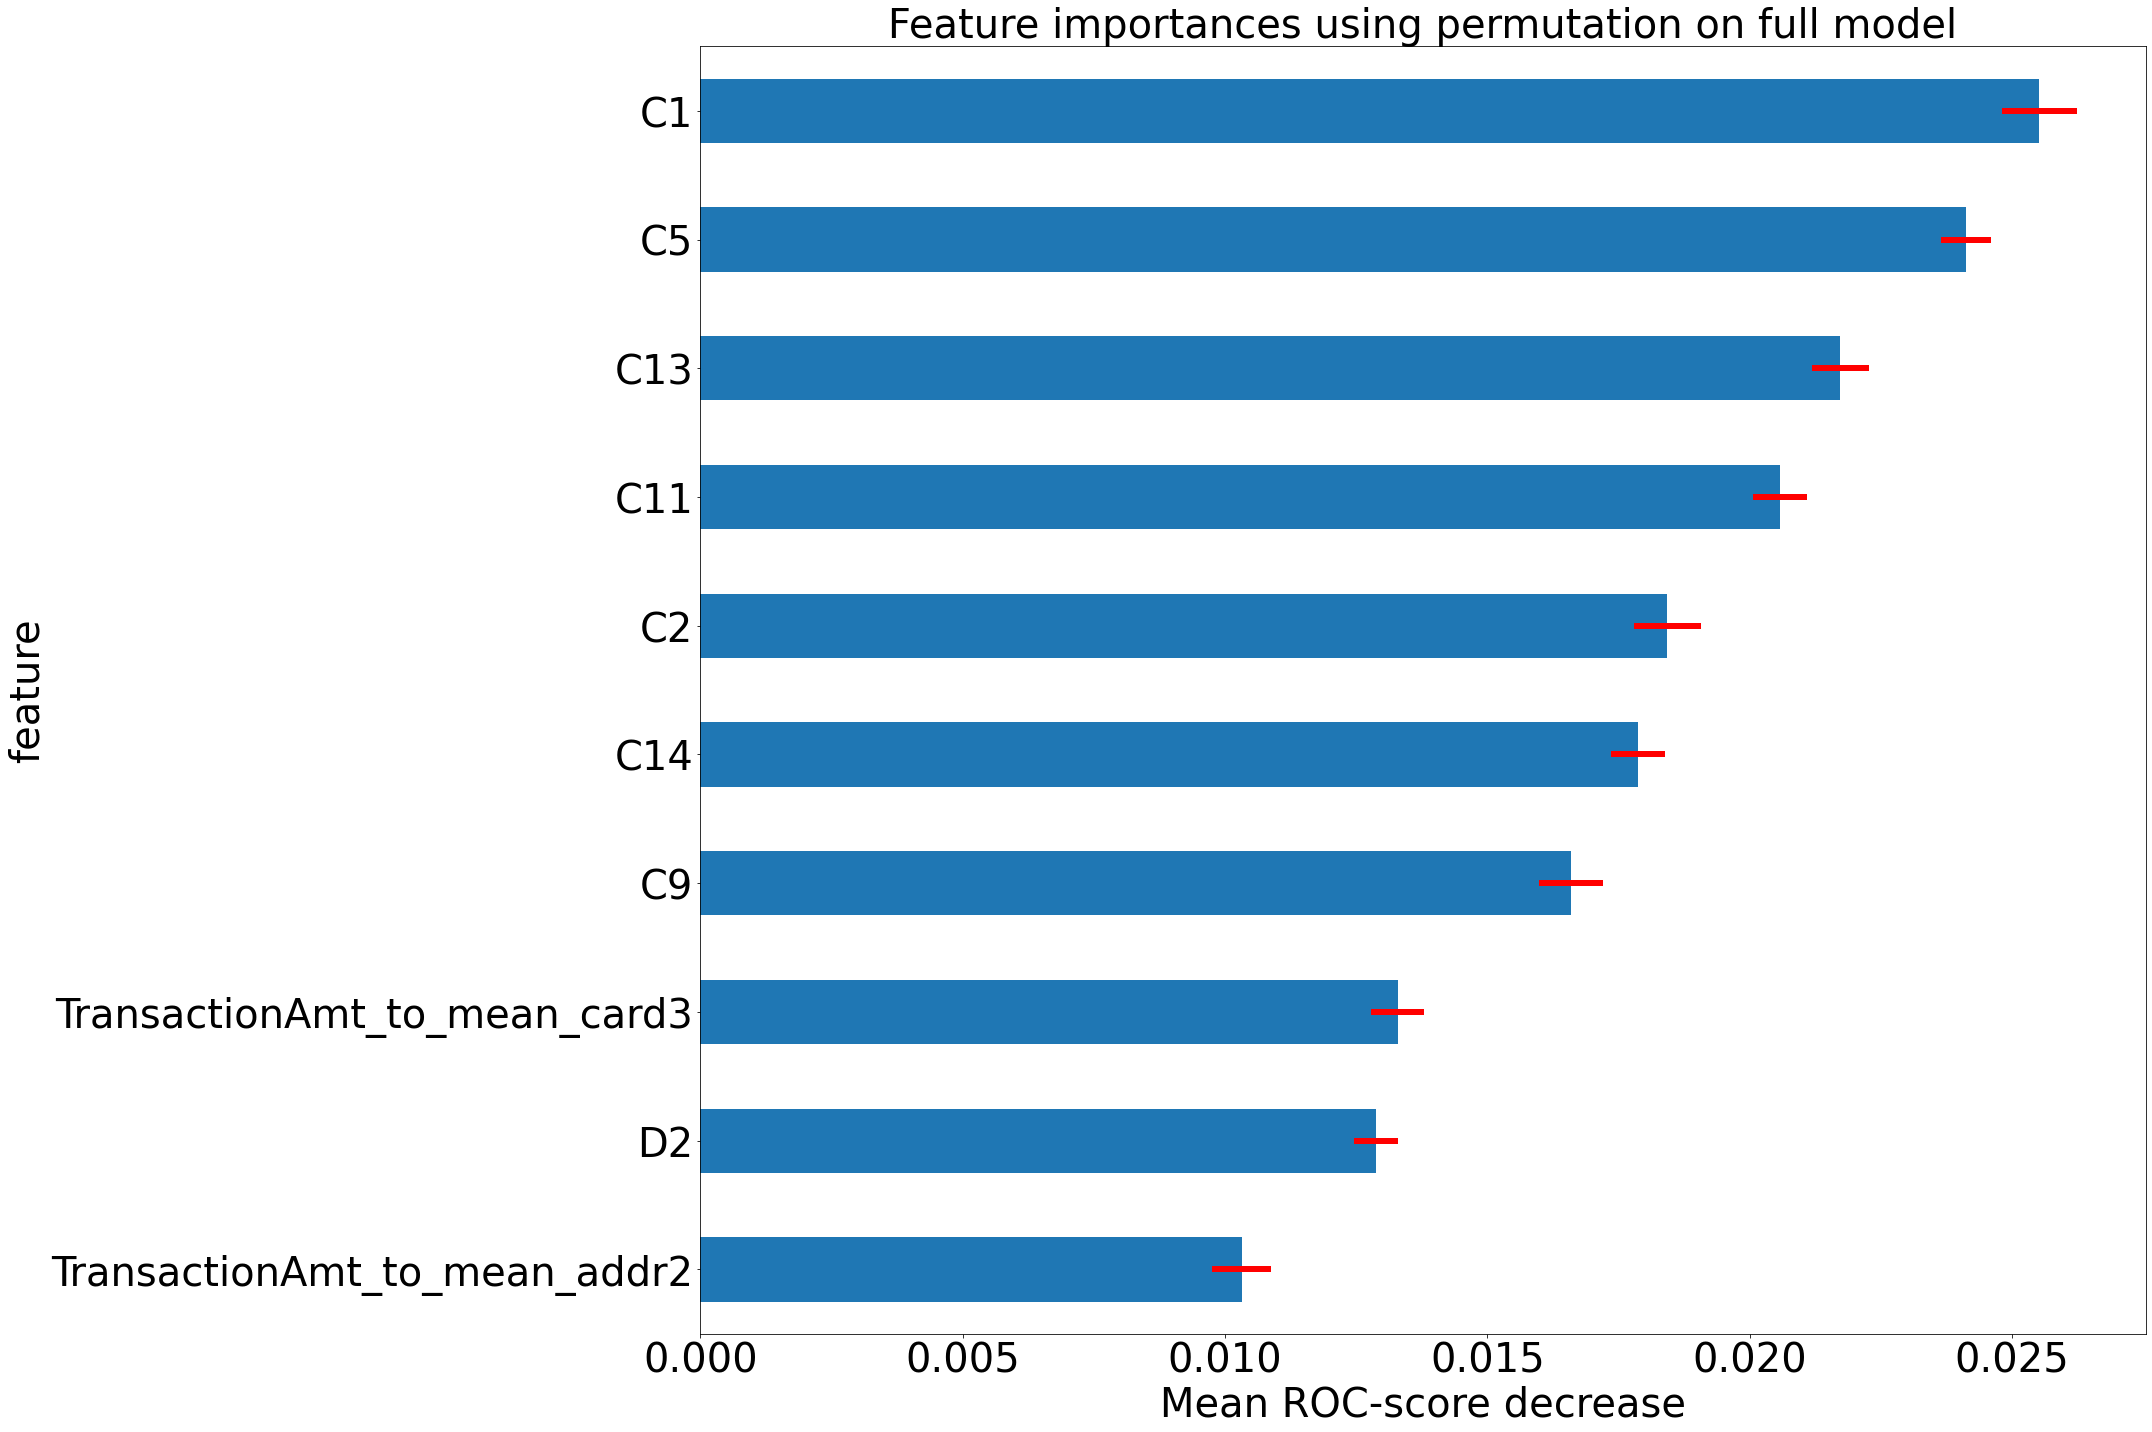

In [76]:
fig, ax = plt.subplots(figsize=(30, 20))
forest_importances.plot.barh(xerr=results.importances_std[coef_name][::-1]/np.sqrt(30), ax=ax, 
                             error_kw =dict({'elinewidth':6}), ecolor="red")
ax.set_title("Feature importances using permutation on full model", size=40)
ax.set_xlabel("Mean ROC-score decrease", size=40)
ax.set_ylabel("feature", size=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
fig.tight_layout()
plt.show()

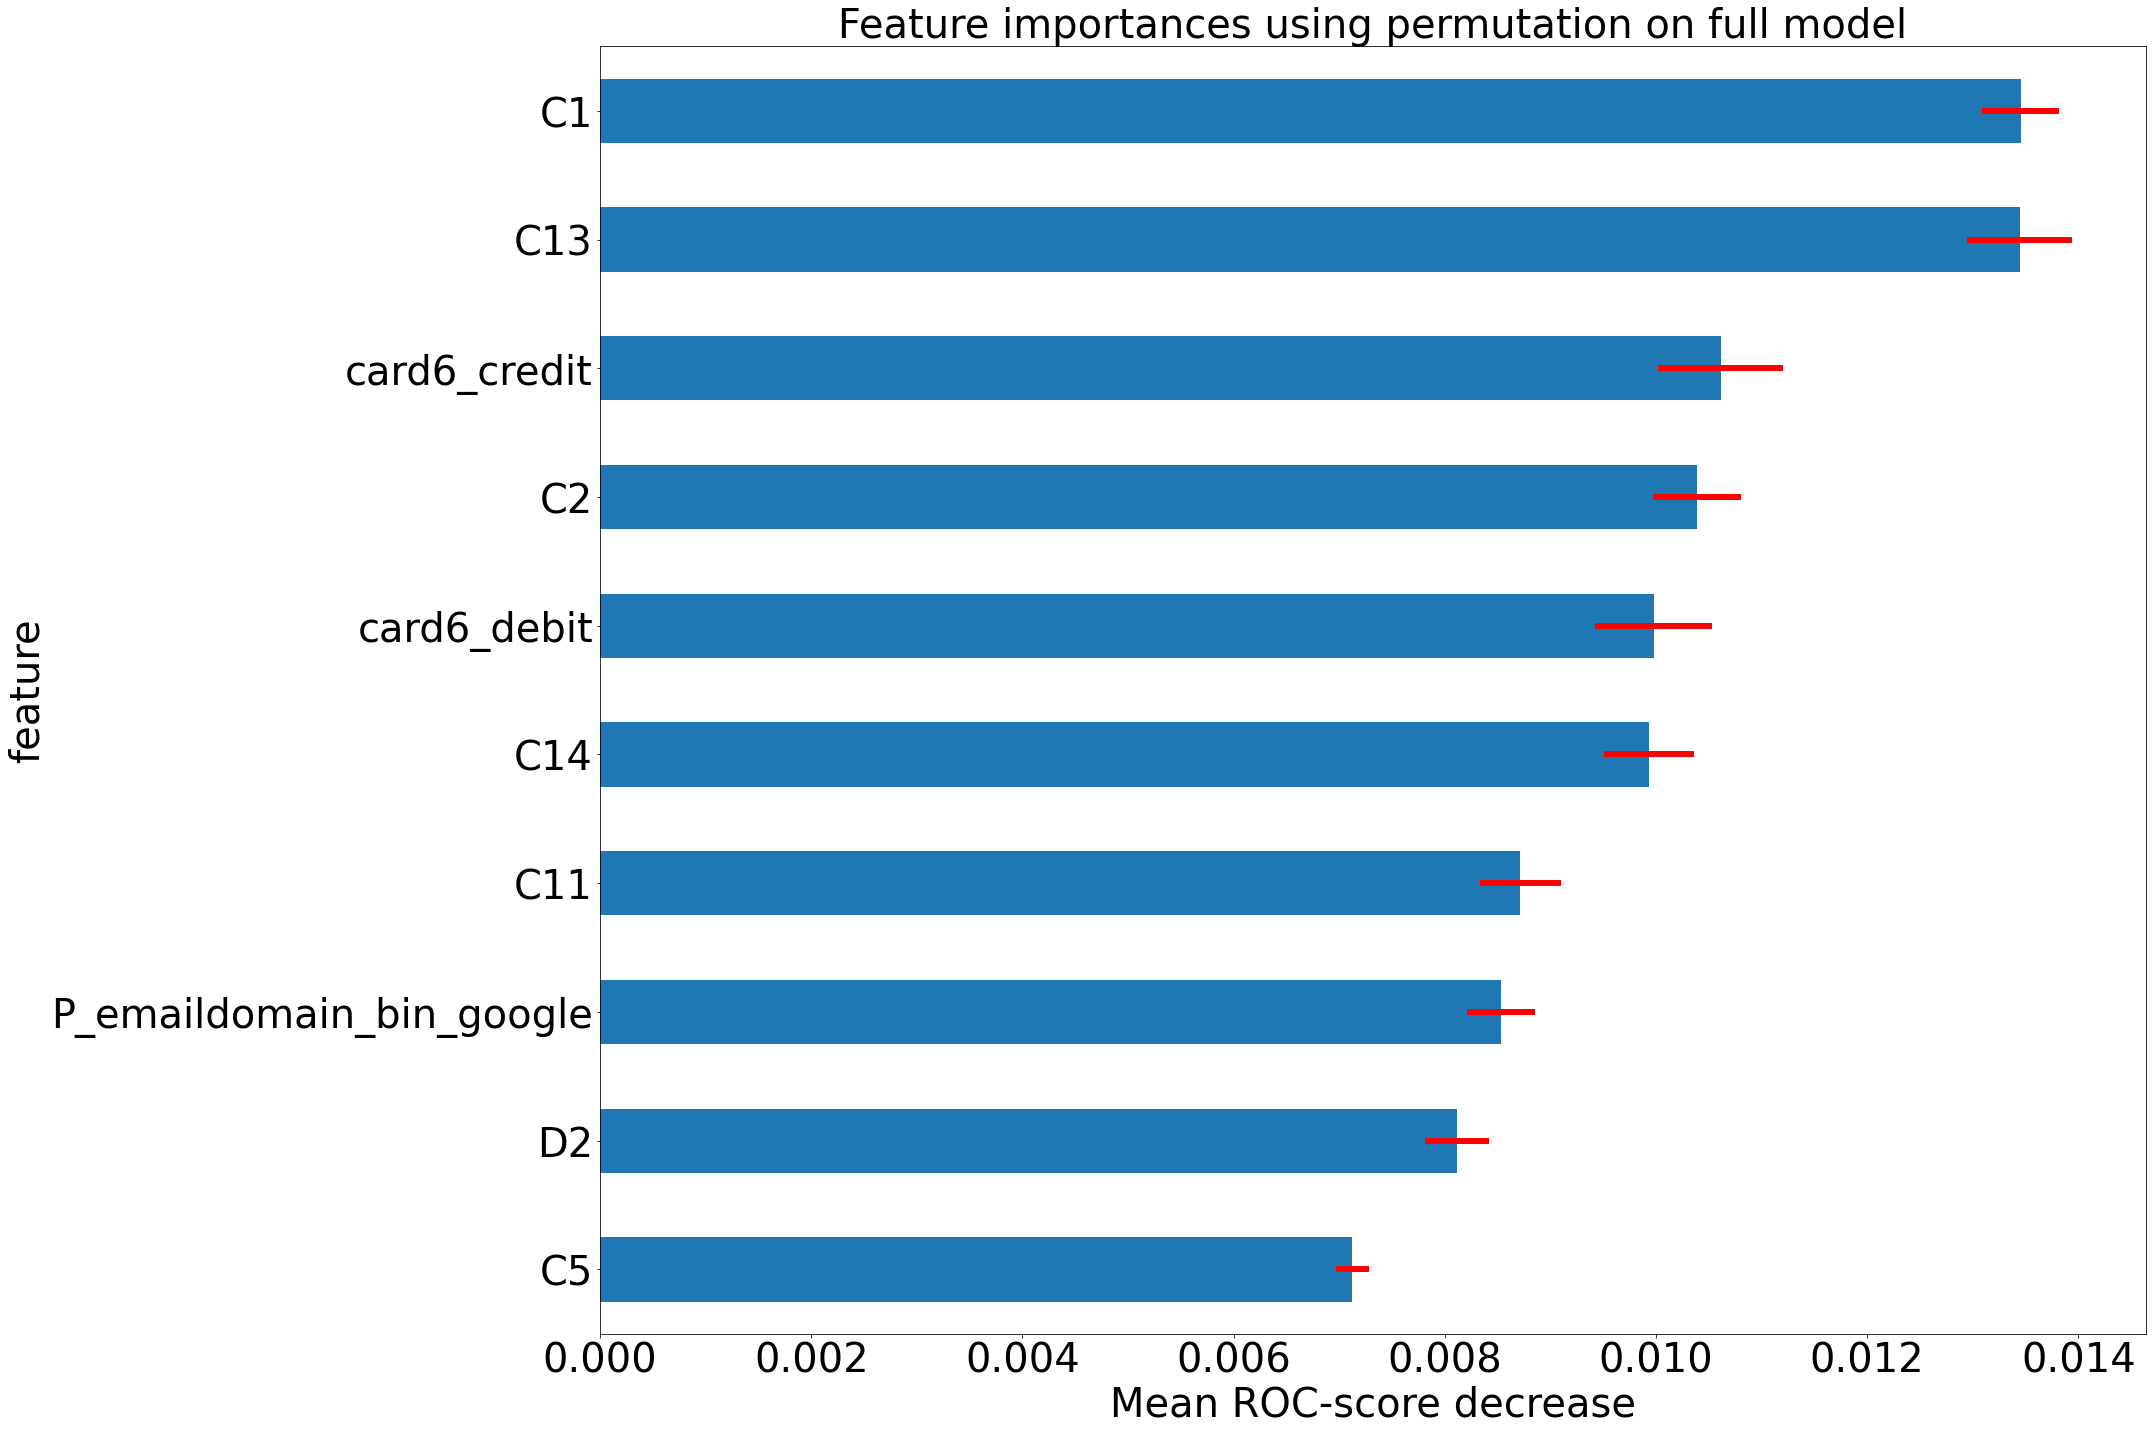

In [84]:
# alternative feature importance (based on permutating the feature values)
# balanced set 
rng = np.random.default_rng(2021)
subsample = rng.choice(X_test.shape[0], size=10000, replace=False)
results = permutation_importance(
    rf_balance, X_test[np.ix_(subsample, select_columns)].toarray(), np.ravel(y_test.iloc[subsample]), n_repeats=30, 
    random_state=2021, n_jobs=5, scoring='roc_auc' 
)
feature_import_top_10 = (np.sort(results.importances_mean))[::-1][:10]
coef_name = np.argsort(results.importances_mean)[::-1][:10]
forest_importances = pd.Series(feature_import_top_10, 
                               index=np.array(feature_names)[select_columns][coef_name])[::-1]
fig, ax = plt.subplots(figsize=(30, 20))
forest_importances.plot.barh(xerr=results.importances_std[coef_name][::-1]/np.sqrt(30), ax=ax, 
                             error_kw =dict({'elinewidth':6}), ecolor="red")
ax.set_title("Feature importances using permutation on full model", size=40)
ax.set_xlabel("Mean ROC-score decrease", size=40)
ax.set_ylabel("feature", size=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
fig.tight_layout()
plt.show()

In [65]:
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), rf.predict_proba(X_test[:, select_columns])[:, 1])

0.886684901833089

In [70]:
recall_score(np.ravel(y_test), rf.predict(X_test[:, select_columns]))

0.29905637551415437

In [87]:
accuracy_score(np.ravel(y_test), rf.predict(X_test[:, select_columns]))

0.9739475734073898

In [88]:
balanced_accuracy_score(np.ravel(y_test), rf.predict(X_test[:, select_columns]))

0.6487385409046973

In [71]:
precision_score(np.ravel(y_test), rf.predict(X_test[:, select_columns]))

0.8728813559322034

In [44]:
# compute test set roc_auc score
roc_auc_score(np.ravel(y_test), rf_l1.predict_proba(X_test[:, select_columns_l1])[:, 1])

0.8784809609970562

In [92]:
roc_auc_score(np.ravel(y_test), rf_balance.predict_proba(X_test[:, select_columns])[:, 1])

0.9161165060806915

In [89]:
balanced_accuracy_score(np.ravel(y_test), rf_balance.predict(X_test[:, select_columns]))

0.8111417107433592

In [90]:
accuracy_score(np.ravel(y_test), rf_balance.predict(X_test[:, select_columns]))

0.9379296914688251

In [66]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [68]:
recall_score(np.ravel(y_test), rf_balance.predict(X_test[:, select_columns]))

0.6748124848778128

In [69]:
precision_score(np.ravel(y_test), rf_balance.predict(X_test[:, select_columns]))

0.3177985414767548

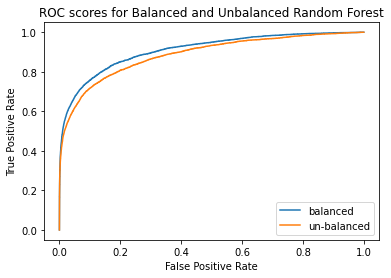

In [86]:
# display roc curve for the test set
fpr, tpr, thresholds = metrics.roc_curve(np.ravel(y_test), 
                         rf_balance.predict_proba(X_test[:, select_columns])[:, 1] , pos_label=1)
plt.plot(fpr, tpr, label="balanced")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC scores for Balanced and Unbalanced Random Forest")
fpr, tpr, thresholds = metrics.roc_curve(np.ravel(y_test), 
                                         rf.predict_proba(X_test[:, select_columns])[:, 1] , pos_label=1)
plt.plot(fpr, tpr, label="un-balanced")
plt.legend()
plt.savefig('rf-plot-roc-compare.png', dpi=300)
plt.show()

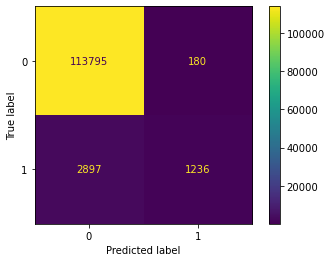

In [66]:
# display confusion matrix for the test set
ConfusionMatrixDisplay.from_estimator(rf, X_test[:, select_columns], np.ravel(y_test))

In [77]:
(113925 + 774)/(113795+180+2897+1236)

0.9711365868527111

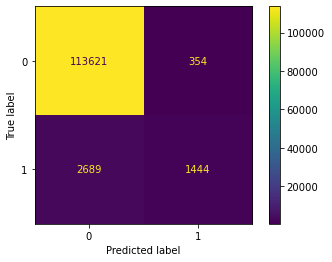

In [116]:
y_pred_thres_low = rf.predict_proba(X_test[:, select_columns])[:, 1] > 0.396
ConfusionMatrixDisplay.from_predictions(np.ravel(y_test), y_pred_thres_low)

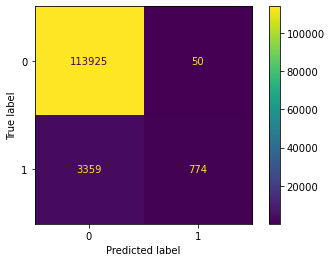

In [68]:
y_pred_thres_high = rf.predict_proba(X_test[:, select_columns])[:, 1] > 0.7
ConfusionMatrixDisplay.from_predictions(np.ravel(y_test), y_pred_thres_high)

[Text(558.0, 906.0, 'C7 <= 0.011\ngini = 0.068\nsamples = 472432\nvalue = [455902, 16530]\nclass = legit'),
 Text(279.0, 543.6, 'C14 <= -0.157\ngini = 0.059\nsamples = 467553\nvalue = [453360, 14193]\nclass = legit'),
 Text(139.5, 181.19999999999993, 'gini = 0.244\nsamples = 28584\nvalue = [24516, 4068]\nclass = legit'),
 Text(418.5, 181.19999999999993, 'gini = 0.045\nsamples = 438969\nvalue = [428844, 10125]\nclass = legit'),
 Text(837.0, 543.6, 'C13 <= -0.101\ngini = 0.499\nsamples = 4879\nvalue = [2542, 2337]\nclass = legit'),
 Text(697.5, 181.19999999999993, 'gini = 0.465\nsamples = 3333\nvalue = [1227, 2106]\nclass = fraud'),
 Text(976.5, 181.19999999999993, 'gini = 0.254\nsamples = 1546\nvalue = [1315, 231]\nclass = legit')]

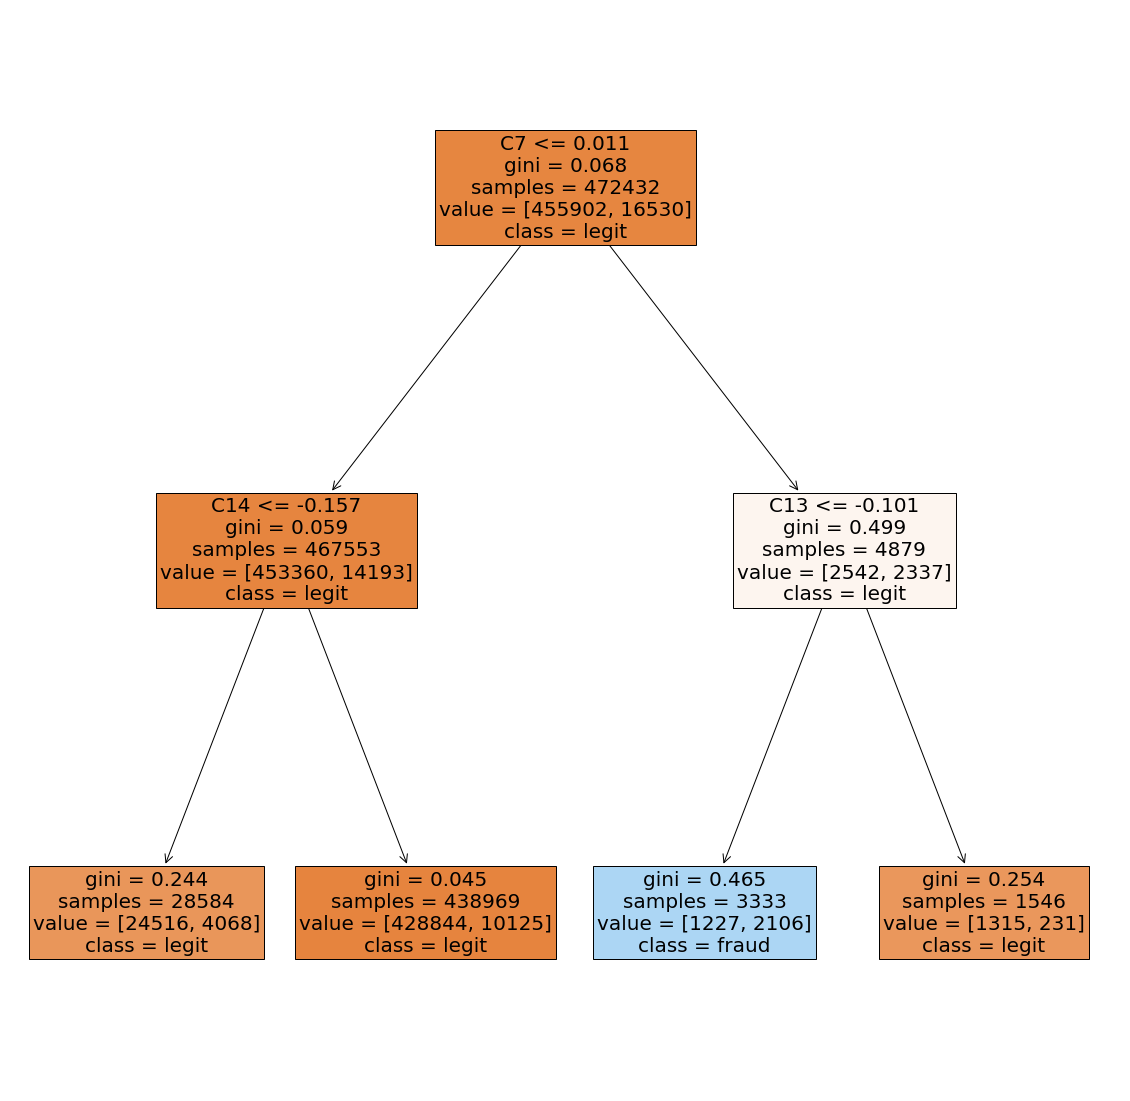

In [71]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
shallow_tree = DecisionTreeClassifier(max_depth=2)
shallow_tree.fit(X_train[:, select_columns], np.ravel(y_train))
plt.figure(figsize=(20, 20))
plot_tree(shallow_tree, fontsize=20, filled=True, feature_names=feature_names[select_columns],
         class_names=['legit','fraud'])

## Fit gradient boosting tree

In [ ]:
#When gathering everything, we had a problem with the package. But this works in other laptops. 

In [ ]:
rng = np.random.default_rng(2021)
subsample = rng.choice(X_train.shape[0], size=100000, replace=False)
parameters = {'n_estimators':[200, 500], 'max_depth':[25, 30, 35], 'num_leaves':[25, 30, 35]}
gb = LGBMClassifier(random_state=2020, is_unbalance=True, objective='binary')
#best_gb = GridSearchCV(gb, parameters, scoring='roc_auc', cv=5, n_jobs=5)
#best_gb.fit(X_train[np.ix_(subsample, select_columns)], np.ravel(y_train.iloc[subsample]))


In [ ]:
#best_gb.best_estimator_

In [ ]:
# roc score for the test set
#prob = best_gb.best_estimator_.predict_proba(X_test[:, select_columns])[:,1]
#roc_auc_score(np.ravel(y_test), prob)

In [ ]:
# features importance based on number of splits
# best_gb.best_estimator_.feature_importances_

In [ ]:
# display roc curve for the test set
# RocCurveDisplay.from_estimator(best_gb.best_estimator_, X_test[:, select_columns], np.ravel(y_test))

In [ ]:
# display confusion matrix for the test set
# ConfusionMatrixDisplay.from_estimator(best_gb.best_estimator_, X_test[:, select_columns], np.ravel(y_test))

In [ ]:
#feature_import = pd.Series(best_gb.best_estimator_.feature_importances_, index=feature_names[select_columns])
#plt.figure(figsize=(30, 20))
#feature_import.plot.bar()
#plt.xlabel("feature", size=15)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.ylabel("number of splits participated", size=15)
#plt.title("Feature Importance with LightGBM", size=20);